In [ ]:
# Set up to save the results from this colab file
import os
import pickle
from google.colab import drive

drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/THESIS" # Where I have my results saved
os.makedirs(save_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install Norse - The Spiking Neural Network Library

!pip install --quiet norse # torch based library for Spiking Neural Networks

In [ ]:
import torch
from torch.utils.data import DataLoader, RandomSampler, BatchSampler
import torchvision
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Download the Datasets and Create the Data Loaders

batch_size = 10 # For the first Epoch


transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
# Create Training and Testing Datasets
train_data_mnist = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transform,
)
test_data_mnist = torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=transform,
)

#Batch Samplers for Dynamic Batch Size setting
sampler_mnist_train = RandomSampler(train_data_mnist)
batch_sampler_mnist_train = BatchSampler(sampler_mnist_train, batch_size=batch_size, drop_last=False)

sampler_mnist_test = RandomSampler(test_data_mnist)
batch_sampler_mnist_test = BatchSampler(sampler_mnist_test, batch_size=batch_size, drop_last=False)


#Data Loaders for MNIST Dataset
train_loader_mnist = DataLoader(
    train_data_mnist, batch_sampler=batch_sampler_mnist_train
)
test_loader_mnist = DataLoader(
    test_data_mnist, batch_sampler = batch_sampler_mnist_test)

# Now the same for fashionMNIST-->

# Training and Testing FashionMNIST Datasets
train_data_fashion = torchvision.datasets.FashionMNIST(
    root=".",
    train=True,
    download=True,
    transform=transform,
)

test_data_fashion = torchvision.datasets.FashionMNIST(
    root=".",
    train=False,
    transform=transform,
)

#Batch Samplers
sampler_fashion_train = RandomSampler(train_data_fashion)
batch_sampler_fashion_train = BatchSampler(sampler_fashion_train, batch_size=batch_size, drop_last=False)

sampler_fashion_test = RandomSampler(test_data_fashion)
batch_sampler_fashion_test = BatchSampler(sampler_fashion_test, batch_size=batch_size, drop_last=False)


# Data Loaders
train_loader_fashion = DataLoader(
    train_data_fashion, batch_sampler=batch_sampler_fashion_train
)
test_loader_fashion = DataLoader(
    test_data_fashion, batch_sampler = batch_sampler_fashion_test
)

/usr/local/lib/python3.11/dist-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
/usr/local/lib/python3.11/dist-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFBoxParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(


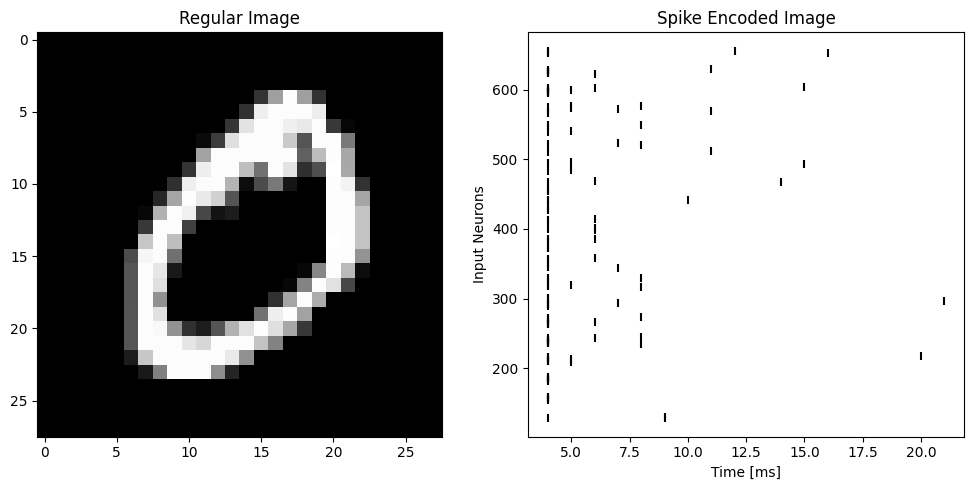

In [ ]:
# For the SNN, the Data must be encoded as Spike Data. We will use norse's latency encoder

from norse.torch.module.encode import SpikeLatencyLIFEncoder

T = 32 # Lenght of Encoded Spike Train
SL_encoder = SpikeLatencyLIFEncoder(T)

# Look at one example in image, and spike-encoded form

# Regular image example
image, label = train_data_mnist[1]

# Encode the image data into spikes
example_image = SL_encoder(image)
example_spikes = example_image.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

# Visualize both

plt.figure(figsize = (10 ,5))

plt.subplot(1 ,2, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title("Regular Image")

plt.subplot(1 ,2 ,2)
plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Neurons")
plt.xlabel("Time [ms]")
plt.title("Spike Encoded Image")

plt.tight_layout()
plt.show()


In [ ]:
# Create the maximum-voltage-decoder for the output layer
# This decoder takes the maximum voltage from every neuron in the output layer and interprets it as a probability distribution
# Neuron with the highest voltage is chosen as network's response

def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y


In [ ]:
# Create the SNN Class

from norse.torch.module.lif import LIFCell, LIFRecurrentCell
from norse.torch import LIFParameters, LIFState, LICell, LIState
from typing import NamedTuple

class SNNState(NamedTuple):
    lif0: LIFState
    readout: LIState


class SNN(torch.nn.Module):
    def __init__(
        self, input_features, hidden_features, output_features, record=False, dt=0.001
    ):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100, v_th=torch.tensor(0.5)),
            dt=dt,
        )

        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.input_features = input_features
        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z=torch.zeros(seq_length, batch_size, self.hidden_features),
                    v=torch.zeros(seq_length, batch_size, self.hidden_features),
                    i=torch.zeros(seq_length, batch_size, self.hidden_features),
                ),
                LIState(
                    v=torch.zeros(seq_length, batch_size, self.output_features),
                    i=torch.zeros(seq_length, batch_size, self.output_features),
                ),
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts, :] = s1.z
                self.recording.lif0.v[ts, :] = s1.v
                self.recording.lif0.i[ts, :] = s1.i
                self.recording.readout.v[ts, :] = so.v
                self.recording.readout.i[ts, :] = so.i
            voltages += [vo]

        return torch.stack(voltages)

# Create Recording Model to capture Neuron activity during training and Testing



In [ ]:
# Create the Network Model Class

class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decode

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = decode(x)
        return log_p_y

In [ ]:
# Setup the SNN

LR = 0.002
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 25
OUTPUT_FEATURES = 10

# Use GPU if possible, for increased performance
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

# TCreate the SNN Model

SNN_model = Model(
    encoder=SL_encoder,
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode,
).to(DEVICE)

# Chose the optmizer for training

optimizer = torch.optim.Adam(SNN_model.parameters(), lr=LR)

In [ ]:
# Create the ANN Class

from torch import nn

class ANN(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
                  nn.Linear(28*28, 25),
                  nn.ReLU(),
                  nn.Linear(25,25),
                  nn.ReLU(),
                  nn.Linear(25,10),
                  )

  def forward(self,x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

# Create the ANN Model

ANN_model = ANN().to(DEVICE)

In [ ]:
# More imports required to perform the analyses

from scipy.spatial import distance
from scipy.spatial.distance import pdist, squareform
import scipy.stats as stats
from sklearn.manifold import MDS
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
class PerformanceTracker:
    def __init__(self, model, train_loader, test_loader, device,
                 epochs=10, learning_rate=0.002,
                 intra_epoch_intervals=60000, target_accuracy=80,
                 dataset_name='MNIST'):
        self.device = device
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.epochs = epochs
        self.target_accuracy = target_accuracy
        self.dataset_name = dataset_name

        # Setup the Recording Models
        self.model_type = 'SNN' if hasattr(model, 'snn') else 'ANN'
        self.base_model = model
        self.recording_model = (self._create_snn_recording_model(model) if self.model_type == 'SNN'
                              else self._create_ann_recording_model(model))
        self.recording_model = self.recording_model.to(device)

        # Training Setup
        self.optimizer = torch.optim.Adam(self.base_model.parameters(), lr=learning_rate)

        # Metrics Storage intra-epoch
        self.intra_epoch_metrics = {
            'steps': [],
            'accuracies': [],
            'distinguishability_correlations': [],
            'centroids': [],
            'distances': []
        }
        # Metrics Storage between epochs
        self.epoch_metrics = {
            'accuracies':[],
            'distinguishability_correlations':[],
            'centroids':[],
            'distances':[]
        }

        # Determine how often Checkpoints should be analyzed
        self.total_training_steps = len(train_loader)
        self.checkpoint_interval = max(1, self.total_training_steps // intra_epoch_intervals)


    def _create_snn_recording_model(self, original_model):
        class RecordingSNNModel(torch.nn.Module):
            def __init__(self, original_model):
                super().__init__()
                self.original_model = original_model
                self.encoder = original_model.encoder
                self.snn = original_model.snn
                self.decoder = original_model.decoder
                self.spike_recordings = None

            def forward(self, x):
                x = self.encoder(x)
                seq_length, batch_size, _, _, _ = x.shape
                s1 = so = None
                voltages = []
                spike_trains = []

                for ts in range(seq_length):
                    z = x[ts, :, :, :].view(-1, self.snn.input_features)
                    z, s1 = self.snn.l1(z, s1)
                    z = self.snn.fc_out(z)
                    vo, so = self.snn.out(z, so)
                    spike_trains.append(s1.z.detach().cpu().numpy())
                    voltages += [vo]

                self.spike_recordings = np.array(spike_trains)
                output = torch.stack(voltages)
                return self.decoder(output)

        return RecordingSNNModel(original_model)

    def _create_ann_recording_model(self, original_model):   # I THINK THIS ONE I STILL NEED
        class RecordingANNModel(torch.nn.Module):
            def __init__(self, original_model):
                super().__init__()
                self.original_model = original_model
                self.model = original_model
                self.hidden_activations = None

            def forward(self, x):
                x = self.model.flatten(x)
                hidden_layer1 = self.model.linear_relu_stack[0](x)
                hidden_layer1_activated = self.model.linear_relu_stack[1](hidden_layer1)
                self.hidden_activations = hidden_layer1_activated.detach().cpu().numpy()
                return self.model.linear_relu_stack(x)

        return RecordingANNModel(original_model)

    def test_epoch(self):
        self.recording_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.recording_model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += len(target)

            return 100.0 * correct / total

    # Analyze Clusters and Performance Correlations
    def analyze_distinguishability(self):
        self.recording_model.eval()
        activations = {i: [] for i in range(10)}

        with torch.no_grad():
            for data, targets in self.test_loader:
                data = data.to(self.device)
                _ = self.recording_model(data)

                recordings = (self.recording_model.spike_recordings if self.model_type == 'SNN'
                            else self.recording_model.hidden_activations)

                for i, target in enumerate(targets):
                    digit = target.item()
                    if self.model_type == 'SNN':
                        avg_pattern = recordings[:, i, :].mean(axis=0)
                        activations[digit].append(avg_pattern)
                    else:
                        activations[digit].append(recordings[i])

        centroids = {digit: np.mean(patterns, axis=0)
                    for digit, patterns in activations.items()}

        centroid_vectors = np.array([centroids[i] for i in range(10)])
        distances = distance.cdist(centroid_vectors, centroid_vectors, metric='euclidean')

        confusion_matrix_result = self._get_confusion_matrix()
        spearman_corr, _ = self._compute_correlations(confusion_matrix_result, distances)

        return spearman_corr, distances, centroids

    def train_first_epoch(self):
        self.recording_model.train()
        target_reached = False

        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()

            output = self.recording_model(data)
            loss = (torch.nn.functional.nll_loss(output, target) if self.model_type == 'SNN'
                   else torch.nn.functional.cross_entropy(output, target))

            loss.backward()
            self.optimizer.step()

            # Check progress at checkpoints
            if batch_idx % self.checkpoint_interval == 0:
                progress = (batch_idx / self.total_training_steps) * 100

                # Test accuracy and distinguishability at this checkpoint
                accuracy = self.test_epoch()
                spearman_corr, distances, centroids = self.analyze_distinguishability()

                # Save metrics
                self.intra_epoch_metrics['steps'].append(progress)
                self.intra_epoch_metrics['accuracies'].append(accuracy)
                self.intra_epoch_metrics['distinguishability_correlations'].append(spearman_corr)
                self.intra_epoch_metrics['centroids'].append(centroids)
                self.intra_epoch_metrics['distances'].append(distances)

                print(f"Progress: {progress:.2f}%, Accuracy: {accuracy:.2f}%")

                if accuracy >= self.target_accuracy:
                    target_reached = True
                    break

        return target_reached, spearman_corr

    def train_epoch(self, epoch_num):
      self.recording_model.train()

      for data, target in self.train_loader:
        data, target = data.to(self.device), target.to(self.device)
        self.optimizer.zero_grad()

        output = self.recording_model(data)
        loss = (torch.nn.functional.nll_loss(output, target) if self.model_type == 'SNN'
               else torch.nn.functional.cross_entropy(output, target))

        loss.backward()
        self.optimizer.step()

      accuracy = self.test_epoch()
      spearman_corr, distances, centroids = self.analyze_distinguishability()

      return accuracy, spearman_corr, distances, centroids


    def _get_confusion_matrix(self):
        self.recording_model.eval()
        preds, targets = [], []

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.recording_model(data)
                pred = output.argmax(dim=1)
                preds.extend(pred.cpu().numpy())
                targets.extend(target.cpu().numpy())

        return confusion_matrix(targets, preds)

    def _compute_correlations(self, confusion_matrix, distance_matrix):
        mask = ~np.eye(confusion_matrix.shape[0], dtype=bool)
        return stats.spearmanr(confusion_matrix[mask], distance_matrix[mask])


    ### THE MAIN TRAINING LOOP STARTS HERE ###

    def run_training(self):
        print(f"Training {self.model_type} on {self.dataset_name}")

        # Reset model weights
        def weight_reset(m):
            if isinstance(m, torch.nn.Linear):
                m.reset_parameters()
        self.recording_model.apply(weight_reset)

        # Train first epoch and collect metrics during training
        print("Training first epoch...")
        target_reached, first_epoch_corr = self.train_first_epoch()

        self.epoch_metrics['accuracies'].append(self.intra_epoch_metrics['accuracies'][-1])
        self.epoch_metrics['distinguishability_correlations'].append(first_epoch_corr)
        self.epoch_metrics['distances'].append(self.intra_epoch_metrics['distances'][-1])

        if target_reached:
            self.train_loader.batch_sampler.batch_size = 128
            for epoch in range(2, self.epochs + 1):
                print(f"Training epoch {epoch}...")
                accuracy, spearmann_corr, distances, centroids = self.train_epoch(epoch)

                self.epoch_metrics["accuracies"].append(accuracy)
                self.epoch_metrics["distinguishability_correlations"].append(spearmann_corr)
                self.epoch_metrics["centroids"].append(centroids)
                self.epoch_metrics["distances"].append(distances)

                print(f"Epoch {epoch}: Accuracy = {accuracy:.2f}%")

                if accuracy >= 81: # Adjust target accuracy for 10 epochs based on the network Type and Dataset
                    print(f"Target accuracy {self.target_accuracy}% reached!")
                    break

        results = (self.intra_epoch_metrics, self.epoch_metrics)
        # Save Results to a pickle file
        save_file = os.path.join(save_path, f'{self.model_type}_{self.dataset_name}_results.pkl')
        with open(save_file, 'wb') as f:
             pickle.dump(results, f)
        print("Training complete.")

        self.plot_results()
        return results

    def plot_results(self):
        plt.figure(figsize=(20, 5))

        # First epoch progress
        plt.subplot(141)
        plt.plot(self.intra_epoch_metrics['steps'],
                self.intra_epoch_metrics['accuracies'], 'b-')
        plt.title('First Epoch:\nAccuracy')
        plt.xlabel('Training Progress (%)')
        plt.ylabel('Accuracy (%)')

        # First epoch distinguishability
        plt.subplot(142)
        plt.plot(self.intra_epoch_metrics['steps'],
                self.intra_epoch_metrics['distinguishability_correlations'], 'r-')
        plt.title('First Epoch:\nTraining Progress vs. Cluster Distinguishablility')
        plt.xlabel('Training Progress (%)')
        plt.ylabel('Accuracy - Distinguishability Correlation')

        # First epoch correlation
        plt.subplot(143)
        plt.plot(self.intra_epoch_metrics['accuracies'],
                   self.intra_epoch_metrics['distinguishability_correlations'], 'g-')
        plt.title('First Epoch:\nAccuracy vs Cluster Distinguishability')
        plt.xlabel('Accuracy (%)')
        plt.ylabel('Accuracy - Distinguishability Correlation')

        # Plot Cluster distance against performance for full training
        plt.subplot(144)
        plt.plot(self.epoch_metrics['accuracies'], self.epoch_metrics['distinguishability_correlations'], 'y-')
        plt.title('Full Training:\nAccuracy vs Distinguishability')
        plt.xlabel('Accuracy (%)')
        plt.ylabel('Cluster Distinguishability correlation')

        plt.tight_layout()
        plt.show()

In [110]:
# Initialize trackers for SNNs
snn_tracker = PerformanceTracker(
    model=SNN_model,
    train_loader=train_loader_fashion, # Chose train_loader_fashion or train_loader_mnist
    test_loader=test_loader_fashion,   # Chose test_loader_fashion or test_loader_mnist
    device=DEVICE,
    target_accuracy=60, # Target accuracy for first epoch
    dataset_name='fashionMNIST' # Chose name accordingly
)

# Run training
snn_results_fashion = snn_tracker.run_training()
snn_results_mnist = snn_tracker.run_training()

# Similarly for ANN
ann_tracker = PerformanceTracker(
    model=ANN_model,
    train_loader = train_loader_fashion, # Chose train_loader_fashion/train_loader_mnist
    test_loader = test_loader_fashion,   # Chose test_loader_fashion/test_loader_mnist
    device=DEVICE,
    target_accuracy=60, # Target accuracy for first epoch
    dataset_name='fashionMNIST' # Chose name 'MNIST' or 'fashionMNIST'
)

#ann_results_fashion = ann_tracker.run_training()
#ann_results_mnist = ann_tracker.run_training()

Training SNN on fashionMNIST
Training first epoch...


KeyboardInterrupt: 

In [ ]:
# Load the Results into the colab environment for Analysis

pickle_files = [f for f in os.listdir(save_path) if f.endswith(".pkl")]

all_data = {}  # Dictionary to store loaded data

for file in pickle_files:
    file_path = os.path.join(save_path, file)
    with open(file_path, "rb") as f:
        all_data[file] = pickle.load(f)  # Store in a dictionary

# Example: Accessing data
for key, value in all_data.items():
    print(f"Loaded {key}: {type(value)}")


In [ ]:
# Compare Cluster Distances between ANN and SNN for FashionMNIST

d_matrix_ANN_fashionMNIST = all_data["ANN_fashionMNIST_results.pkl"][1]["distances"][-1] # '0' for first epoch, '1' for last epoch
d_matrix_SNN_fashionMNIST = all_data["SNN_fashionMNIST_results.pkl"][1]["distances"][-1] # '0' for first epoch, '1' for last epoch

mask = ~np.eye(d_matrix_ANN_fashionMNIST.shape[0], dtype=bool)

d_matrix_ANN_fashionMNIST = d_matrix_ANN_fashionMNIST[mask]

mask = ~np.eye(d_matrix_SNN_fashionMNIST.shape[0], dtype=bool)

d_matrix_SNN_fashionMNIST = d_matrix_SNN_fashionMNIST[mask]


state_space_correlations_fashionMNIST = stats.spearmanr(d_matrix_ANN_fashionMNIST, d_matrix_SNN_fashionMNIST)
state_space_correlations_fashionMNIST

SignificanceResult(statistic=0.8210803689064559, pvalue=3.8300953311011047e-23)

In [ ]:
# Compare Cluster Distances between ANN and SNN for MNIST


d_matrix_ANN_MNIST = all_data["ANN_MNIST_results.pkl"][1]["distances"][-1] # '0' for first epoch, '1' for last epoch
d_matrix_SNN_MNIST = all_data["SNN_MNIST_results.pkl"][1]["distances"][-1] # '0' for first epoch, '1' for last epoch

mask = ~np.eye(d_matrix_ANN_MNIST.shape[0], dtype=bool)

d_matrix_ANN_MNIST = d_matrix_ANN_MNIST[mask]

mask = ~np.eye(d_matrix_SNN_MNIST.shape[0], dtype=bool)

d_matrix_SNN_MNIST = d_matrix_SNN_MNIST[mask]


state_space_correlations_MNIST = stats.spearmanr(d_matrix_ANN_MNIST, d_matrix_SNN_MNIST)
state_space_correlations_MNIST

SignificanceResult(statistic=0.5048748353096179, pvalue=3.8871095507115825e-07)